## NREL National Solar Radiation Database (NSRDB) - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

Please consult the README file for setup instructions prior to running this notebook.


In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

## Basic Usage

The NSRDB is provided in annual .h5 files and currently spans 1998-2024.  
Each year can be accessed from /nrel/nsrdb/GOES/aggregated/v4.0.0/nsrdb_${year}.h5

In [2]:
# Open the desired year of nsrdb data
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/nsrdb/GOES/aggregated/v4.0.0/nsrdb_2012.h5")

In [3]:
list(f.attrs)  # list attributes belonging to the root group

['version']

In [4]:
f.attrs['version']   # attributes can be used to provide desriptions of the content

'4.0.1'

## Datasets

In [5]:
# list the datasets in the file
for k in f:
    dset = f[k]
    print(f"{dset.name} {dset.shape}")

/air_temperature (17568, 2018267)
/alpha (17568, 2018267)
/aod (17568, 2018267)
/asymmetry (17568, 2018267)
/cld_opd_dcomp (17568, 2018267)
/cld_press_acha (17568, 2018267)
/cld_reff_dcomp (17568, 2018267)
/clearsky_dhi (17568, 2018267)
/clearsky_dni (17568, 2018267)
/clearsky_ghi (17568, 2018267)
/cloud_fill_flag (17568, 2018267)
/cloud_type (17568, 2018267)
/dew_point (17568, 2018267)
/dhi (17568, 2018267)
/dni (17568, 2018267)
/fill_flag (17568, 2018267)
/ghi (17568, 2018267)
/meta (2018267,)
/ozone (17568, 2018267)
/relative_humidity (17568, 2018267)
/solar_zenith_angle (17568, 2018267)
/ssa (17568, 2018267)
/surface_albedo (17568, 2018267)
/surface_pressure (17568, 2018267)
/time_index (17568,)
/total_precipitable_water (17568, 2018267)
/wind_direction (17568, 2018267)
/wind_speed (17568, 2018267)


In [6]:
# Datasets are stored in a 2d array of time x location
dset = f['ghi']
dset.shape

(17568, 2018267)

In [7]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 30min

DatetimeIndex(['2012-01-01 00:00:00+00:00', '2012-01-01 00:30:00+00:00',
               '2012-01-01 01:00:00+00:00', '2012-01-01 01:30:00+00:00',
               '2012-01-01 02:00:00+00:00', '2012-01-01 02:30:00+00:00',
               '2012-01-01 03:00:00+00:00', '2012-01-01 03:30:00+00:00',
               '2012-01-01 04:00:00+00:00', '2012-01-01 04:30:00+00:00',
               ...
               '2012-12-31 19:00:00+00:00', '2012-12-31 19:30:00+00:00',
               '2012-12-31 20:00:00+00:00', '2012-12-31 20:30:00+00:00',
               '2012-12-31 21:00:00+00:00', '2012-12-31 21:30:00+00:00',
               '2012-12-31 22:00:00+00:00', '2012-12-31 22:30:00+00:00',
               '2012-12-31 23:00:00+00:00', '2012-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17568, freq=None)

In [8]:
# Locational information is stored in either 'meta' or 'coordinates'
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,elevation,timezone,country,state,county
0,-15.950000,-179.979996,0,12,b'nan',b'nan',b'nan'
1,-15.990000,-179.979996,0,12,b'nan',b'nan',b'nan'
2,-16.030001,-179.979996,0,12,b'nan',b'nan',b'nan'
3,-16.070000,-179.979996,0,12,b'nan',b'nan',b'nan'
4,-16.110001,-179.979996,0,12,b'nan',b'nan',b'nan'


In [9]:
# ghi dataset have been saved as integers
dset.dtype

dtype('uint16')

In [10]:
dset.shape[0] * dset.shape[1] * 2 * 10**-9 # 70 GB per dataset!

70.913829312

In [11]:
dset.chunks # Chunked by week

(2000, 500)

In [12]:
dset.chunks[0] * dset.chunks[1] * 2 * 10**-6 # 2 MB per chunk

2.0

In [13]:
# To convert dataset values back to floats use the 'psm_scale_factor'
dset.attrs['psm_scale_factor'] # Irradiance values have been truncated to integer precision

1.0

In [14]:
# wind speed on the other hand has single decimal percision when scaled by 10
scale_factor = f['wind_speed'].attrs['psm_scale_factor']
#. units = f['wind_speed'].attrs['psm_units']. # tbd - this attribute doesn't exist
print('wind_speed scale factor = ', scale_factor)
# print('wind_speed units after unscaling = ', units)
f['wind_speed'][0, 0] / scale_factor # divide by scale_factor to return native value

wind_speed scale factor =  10.0


3.3

## Time-slicing

Get the time_index from the server and convert to a pandas DatetimeIndex for convenience:

In [15]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2012-01-01 00:00:00+00:00', '2012-01-01 00:30:00+00:00',
               '2012-01-01 01:00:00+00:00', '2012-01-01 01:30:00+00:00',
               '2012-01-01 02:00:00+00:00', '2012-01-01 02:30:00+00:00',
               '2012-01-01 03:00:00+00:00', '2012-01-01 03:30:00+00:00',
               '2012-01-01 04:00:00+00:00', '2012-01-01 04:30:00+00:00',
               ...
               '2012-12-31 19:00:00+00:00', '2012-12-31 19:30:00+00:00',
               '2012-12-31 20:00:00+00:00', '2012-12-31 20:30:00+00:00',
               '2012-12-31 21:00:00+00:00', '2012-12-31 21:30:00+00:00',
               '2012-12-31 22:00:00+00:00', '2012-12-31 22:30:00+00:00',
               '2012-12-31 23:00:00+00:00', '2012-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17568, freq=None)

Extract indexes for a particular span of time:

In [16]:
march = time_index.month == 3
np.where(march)[0]

array([2880, 2881, 2882, ..., 4365, 4366, 4367])

Or a particular date:

In [17]:
timestep = np.where(time_index == '2012-07-04 00:00:00')[0][0]
timestep

8880

## Map Data

In [18]:
# Extract coordinates (lat, lon)
# prefer a 'coordinates' dataset when present, else fall back to 'meta'
try:
    coords_arr = f['coordinates'][...]
    coords = pd.DataFrame(coords_arr, columns=['latitude','longitude'])
except Exception:
    coords = pd.DataFrame(f['meta'][...])[['latitude', 'longitude']]

In [19]:
dset = f['ghi']
%time data = dset[timestep, ::10]   # extract every 10th location at a particular time
df = pd.DataFrame() # Combine data with coordinates in a DataFrame
# select every 10th row by position, keep alignment by resetting index
sample_slice = slice(None, None, 10)
df['longitude'] = coords['longitude'].iloc[sample_slice].reset_index(drop=True).values
df['latitude']  = coords['latitude'].iloc[sample_slice].reset_index(drop=True).values
df['ghi']       = data / dset.attrs['psm_scale_factor']

CPU times: user 10.7 ms, sys: 4.38 ms, total: 15.1 ms
Wall time: 56.2 s


In [20]:
df.shape

(201827, 3)

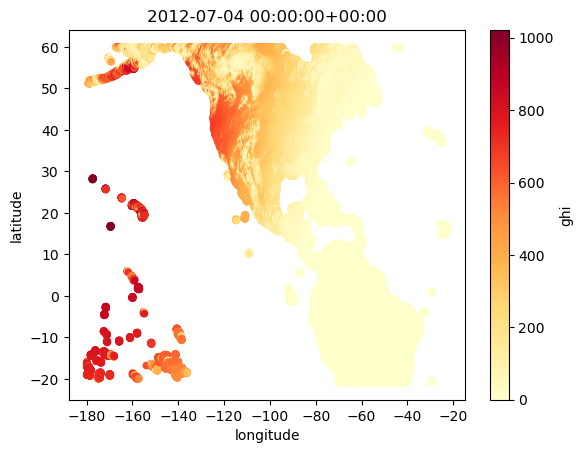

In [21]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [22]:
# Full resolution subset of California
meta = pd.DataFrame(f['meta'][...])
CA = meta.loc[meta['state'] == b'California'] # Note .h5 saves strings as bit-strings
CA.head()

,latitude,longitude,elevation,timezone,country,state,county
110930,40.490002,-124.379997,158,-8,b'United States',b'California',b'Humboldt'
110931,40.450001,-124.379997,160,-8,b'United States',b'California',b'Humboldt'
110932,40.410000,-124.379997,281,-8,b'United States',b'California',b'Humboldt'
111362,40.570000,-124.339996,60,-8,b'United States',b'California',b'Humboldt'
111363,40.529999,-124.339996,201,-8,b'United States',b'California',b'Humboldt'


In [23]:
%time data = dset[timestep][CA.index]  # full-resolution subset
df = CA[['longitude', 'latitude']].copy()
df['ghi'] = data / dset.attrs['psm_scale_factor']
df.shape

CPU times: user 53.1 ms, sys: 14.8 ms, total: 67.9 ms
Wall time: 56.5 s


(25981, 3)

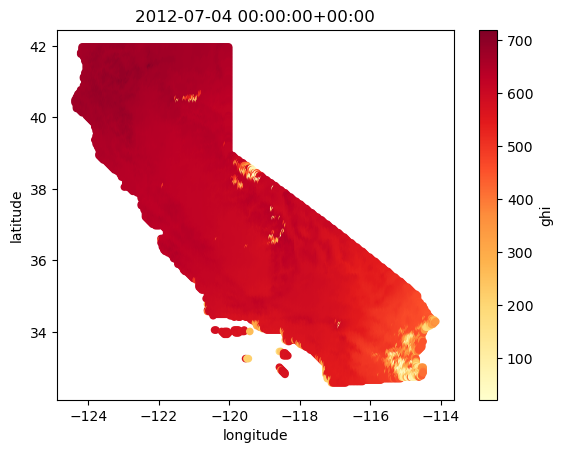

In [24]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

## Nearest Timeseries for given Lat/Lon

In [25]:
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site it using a KDtree

# Some HSDS domains expose a 'coordinates' dataset; others store lat/lon in 'meta'.
try:
    dset_coords = f['coordinates'][...]
except Exception:
    # fall back to meta which includes 'latitude' and 'longitude' columns
    meta = pd.DataFrame(f['meta'][...])
    dset_coords = meta[['latitude', 'longitude']].values

tree = cKDTree(dset_coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = nearest_site(tree, NewYorkCity[0], NewYorkCity[1] )

print("Site index for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(dset_coords[NewYorkCity_idx]))

Site index for New York City: 		 1243965
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 [ 40.73 -74.02]


In [26]:
# Get the entire 2012 timeseries data for a point in NYC
%time tseries = dset[:, NewYorkCity_idx] / dset.attrs['psm_scale_factor']

CPU times: user 5.93 ms, sys: 2.31 ms, total: 8.24 ms
Wall time: 680 ms


In [27]:
len(tseries)   # 1 years * 365 days * 24 hours * 30 minutes

17568

Text(0.5, 1.0, 'NYC ghi in 2012')

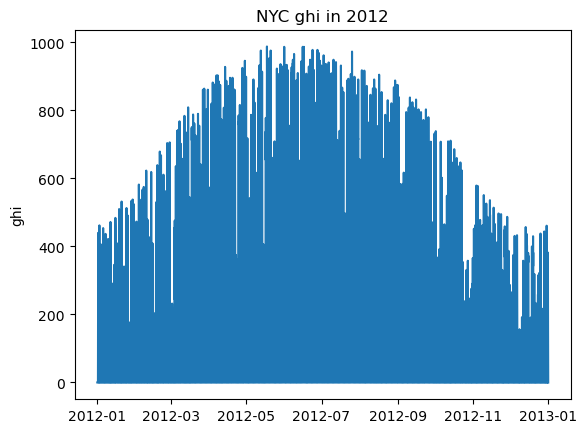

In [28]:
plt.plot(time_index, tseries)
plt.ylabel("ghi")
plt.title("NYC ghi in 2012")

## GHI Statistics

In [29]:
df = pd.DataFrame({'ghi': tseries}, index=time_index)
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour

agg = df.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="ghi")
agg

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,188.532258,295.354839,331.822581,323.048387,300.822581,229.741935,137.741935,49.806452,0.661290,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,281.534483,378.965517,411.172414,441.913793,416.379310,351.344828,253.862069,116.465517,20.379310,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,376.032258,497.564516,538.741935,570.887097,538.016129,484.435484,363.322581,217.258065,82.435484,2.967742
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,568.116667,712.983333,733.066667,683.983333,654.816667,555.933333,446.333333,290.483333,145.466667,27.816667
5,2.193548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,468.161290,567.854839,599.822581,616.758065,606.258065,547.322581,435.419355,326.048387,178.177419,69.838710
6,13.450000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,608.533333,685.583333,755.500000,742.450000,640.550000,585.900000,503.683333,344.683333,219.600000,91.450000
7,11.322581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,572.564516,687.596774,742.709677,730.080645,699.306452,595.596774,512.806452,367.693548,234.145161,97.951613
8,0.483871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,572.370968,667.564516,672.241935,683.516129,677.516129,592.209677,470.274194,318.516129,168.532258,46.338710
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,461.116667,577.733333,608.150000,591.983333,549.850000,463.583333,342.233333,202.066667,72.066667,3.600000


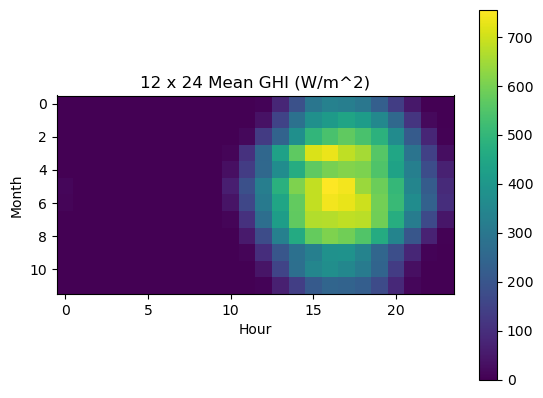

In [30]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean GHI (W/m^2)")
plt.colorbar()